In [47]:
caffe_root = '/home/ubuntu/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
sys.path.append('/home/ubuntu/caffe')
sys.path.append('/home/ubuntu/caffe/python')
! sudo ldconfig /usr/local/cuda/lib64
import caffe
from pandas_confusion import ConfusionMatrix
caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

/sbin/ldconfig.real: /usr/local/cuda/lib64/libcudnn.so.7.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/cuda/lib64/libcudnn.so.5 is not a symbolic link

/sbin/ldconfig.real: /usr/local/cuda/lib64/libcudnn.so.4 is not a symbolic link



In [48]:
import os
weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
assert os.path.exists(weights)

In [49]:
drink_labels = 'drinking', 'no_drinking'
num_drink_labels = 2
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000

In [50]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)   
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
       
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

In [51]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

In [52]:
def drink_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'val'  
    source = caffe_root + 'spectrogram/HR/%s.txt' % subset 
    transform_param = dict(mirror=train, crop_size=227,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    drink_data, drink_labels = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=20, new_height=256, new_width=256, ntop=2)
    return caffenet(data=drink_data, label=drink_labels, train=train,
                    num_classes=num_drink_labels,
                    classifier_name='fc8_drink',
                    learn_all=learn_all)

In [53]:
untrained_drink_net = caffe.Net(drink_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_drink_net.forward()
drink_data_batch = untrained_drink_net.blobs['data'].data.copy()
drink_label_batch = np.array(untrained_drink_net.blobs['label'].data, dtype=np.int32)

In [54]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_drink_preds(net, image):
    disp_preds(net, image, drink_labels, name='drink')

actual label = no_drinking


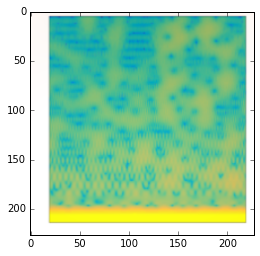

In [55]:
batch_index = 8
image = drink_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', drink_labels[drink_label_batch[batch_index]]

In [56]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels =
	(1) 58.98% n02840245 binder, ring-binder
	(2) 12.68% n03291819 envelope
	(3)  7.81% n03485794 handkerchief, hankie, hanky, hankey
	(4)  7.21% n07248320 book jacket, dust cover, dust jacket, dust wrapper
	(5)  4.94% n03998194 prayer rug, prayer mat


In [57]:
disp_drink_preds(untrained_drink_net, image)

top 5 predicted drink labels =
	(1) 50.00% drinking
	(2) 50.00% no_drinking


In [58]:
diff = untrained_drink_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

In [59]:
del untrained_drink_net

In [60]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.0001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 200  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 2000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'Adam'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 200

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    #s.snapshot = 1000
    #s.snapshot_prefix = caffe_root + 'models/finetune_flickr_style/finetune_flickr_style'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [61]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [62]:
niter = 500 # number of iterations to train

# Reset style_solver as before.
drink_solver_filename = solver(drink_net(train=True))
drink_solver = caffe.get_solver(drink_solver_filename)
drink_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_drink_solver_filename = solver(drink_net(train=True))
scratch_drink_solver = caffe.get_solver(scratch_drink_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', drink_solver),
           ('scratch', scratch_drink_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
drink_weights, scratch_drink_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del drink_solver, scratch_drink_solver, solvers

Running solvers for 500 iterations...
  0) pretrained: loss=0.693, acc=100%; scratch: loss=0.693, acc=100%
 10) pretrained: loss=0.880, acc= 0%; scratch: loss=0.797, acc= 0%
 20) pretrained: loss=0.800, acc=15%; scratch: loss=0.625, acc=100%
 30) pretrained: loss=0.577, acc=100%; scratch: loss=0.743, acc= 0%
 40) pretrained: loss=0.700, acc=25%; scratch: loss=0.669, acc=100%
 50) pretrained: loss=0.664, acc=70%; scratch: loss=0.708, acc= 0%
 60) pretrained: loss=0.720, acc=25%; scratch: loss=0.690, acc=95%
 70) pretrained: loss=0.635, acc=85%; scratch: loss=0.696, acc= 5%
 80) pretrained: loss=0.719, acc=20%; scratch: loss=0.695, acc=10%
 90) pretrained: loss=0.651, acc=80%; scratch: loss=0.694, acc=20%
100) pretrained: loss=0.695, acc=40%; scratch: loss=0.697, acc=15%
110) pretrained: loss=0.653, acc=70%; scratch: loss=0.695, acc=25%
120) pretrained: loss=0.711, acc=30%; scratch: loss=0.695, acc=15%
130) pretrained: loss=0.632, acc=75%; scratch: loss=0.694, acc=35%
140) pretrained: lo

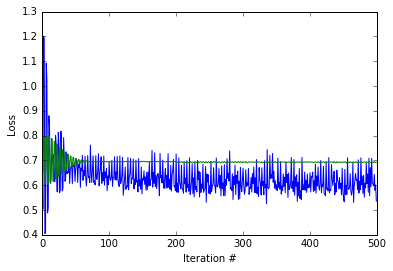

In [63]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

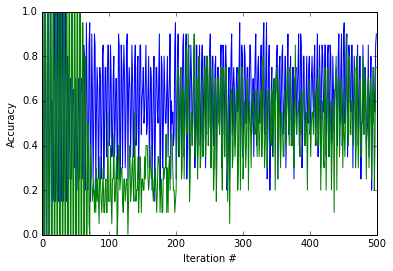

In [64]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

In [65]:
actual = []
with open('/home/ubuntu/caffe/spectrogram/HR/val.txt') as f:
    for line in f:
        if "drinking" in line: 
            actual.append("drinking")
        if "no-drinking" in line:    
            actual.append("no_drinking") 

In [66]:
def eval_drink_net(weights, test_iters=10):
    prediction = []
    test_net = caffe.Net(drink_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for i in range(0,20):
        drinking= test_net.forward()['probs'][i][0]
        no_drinking = test_net.forward()['probs'][i][1]
        if (drinking> no_drinking):
            prediction.append("drinking")
        if (no_drinking> drinking): 
            prediction.append("no_drinking")
    
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    #confusion_matrix = ConfusionMatrix(actual, prediction)
    #print("Confusion matrix:\n%s" % confusion_matrix)    
    return test_net, accuracy

In [67]:
test_net, accuracy = eval_drink_net(drink_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_drink_net(scratch_drink_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, trained from ImageNet initialization: 60.0%
Accuracy, trained from   random initialization: 55.0%


In [68]:
end_to_end_net = drink_net(train=True, learn_all=True)

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).

base_lr = 0.0001

drink_solver_filename = solver(end_to_end_net, base_lr=base_lr)
drink_solver = caffe.get_solver(drink_solver_filename)
drink_solver.net.copy_from(drink_weights)

scratch_drink_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_drink_solver = caffe.get_solver(scratch_drink_solver_filename)
scratch_drink_solver.net.copy_from(scratch_drink_weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained, end-to-end', drink_solver),
           ('scratch, end-to-end', scratch_drink_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

drink_weights_ft = finetuned_weights['pretrained, end-to-end']
scratch_drink_weights_ft = finetuned_weights['scratch, end-to-end']

# Delete solvers to save memory.
del drink_solver, scratch_drink_solver, solvers

Running solvers for 500 iterations...
  0) pretrained, end-to-end: loss=0.679, acc=35%; scratch, end-to-end: loss=0.694, acc=45%
 10) pretrained, end-to-end: loss=0.691, acc=50%; scratch, end-to-end: loss=0.767, acc= 0%
 20) pretrained, end-to-end: loss=0.715, acc=15%; scratch, end-to-end: loss=0.660, acc=100%
 30) pretrained, end-to-end: loss=0.700, acc=90%; scratch, end-to-end: loss=0.714, acc= 0%
 40) pretrained, end-to-end: loss=0.713, acc=15%; scratch, end-to-end: loss=0.682, acc=100%
 50) pretrained, end-to-end: loss=0.606, acc=100%; scratch, end-to-end: loss=0.704, acc= 0%
 60) pretrained, end-to-end: loss=0.695, acc=15%; scratch, end-to-end: loss=0.681, acc=100%
 70) pretrained, end-to-end: loss=0.594, acc=100%; scratch, end-to-end: loss=0.701, acc=75%
 80) pretrained, end-to-end: loss=0.702, acc=15%; scratch, end-to-end: loss=0.620, acc=15%
 90) pretrained, end-to-end: loss=0.580, acc=100%; scratch, end-to-end: loss=0.675, acc=90%
100) pretrained, end-to-end: loss=0.647, acc=2

In [69]:
test_net, accuracy = eval_drink_net(drink_weights_ft)
print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_drink_net(scratch_drink_weights_ft)
print 'Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, finetuned from ImageNet initialization: 65.0%
Accuracy, finetuned from   random initialization: 55.0%
